## Lógica Computacional: 21/22## 
---
##Trabalho 2## 

$Grupo$ $7$ 

*   David José de Sousa Machado (A91665)
*   Ivo Miguel Gomes Lima (A90214)
---
#Inicialização

Para a resolução destes exercícios usamos a biblioteca [Python Z3Py](https://ericpony.github.io/z3py-tutorial/guide-examples.htm) que criou uma interface para o Z3. Esta biblioteca foi instalada com o commando `!pip install z3-solver`.

In [1]:
!pip install z3-solver

     |████████████████████████████████| 33.0 MB 17 kB/s 


In [2]:
import networkx as nx
import random
from z3 import *
import numpy as np

# Problema 1:
1. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 
    >  O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.
    2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.
  
#Implementação

In [3]:
def make_cycle(g, v):
  for i in range(len(v)):
    if v[i-1] == v[i]:
      break
    g.add_edge(v[i-1], v[i])


def gera(N):
  fatores = [fac for fac in range(1, N+1) if N % fac == 0]
  vertices = list(range(N))
  grafo = nx.DiGraph()
  grafo.add_nodes_from(vertices)

  scramble = random.sample(vertices, N)

  length = N
  cycles = []
  while length > 0:
    start = N-length
    n = random.randint(1, length)
    cycles.append(scramble[start : start + n])
    length -= n

  print(cycles)

  link = []
  for i in range(len(cycles)):
    test = cycles[i]+link
    print(test)
    make_cycle(grafo, cycles[i]+link)
    link = random.sample(cycles[i], 1)

  print(grafo.edges, len(grafo.edges))

  for node in grafo.nodes:
    if grafo.out_degree(node) < 3:
      n_new_nodes = random.randint(0, 3 - grafo.out_degree(node))
      if n_new_nodes:
        for dest in random.sample([v for v in vertices if v != node], n_new_nodes):
          grafo.add_edge(node, dest)


  print(grafo.edges)

  return grafo

[[4, 19, 17, 8, 6, 2, 0, 3, 14, 5, 1, 7, 16, 13, 15, 12, 11, 18], [9], [10]]
[4, 19, 17, 8, 6, 2, 0, 3, 14, 5, 1, 7, 16, 13, 15, 12, 11, 18]
[9, 3]
[10, 9]
[(0, 3), (1, 7), (2, 0), (3, 14), (3, 9), (4, 19), (5, 1), (6, 2), (7, 16), (8, 6), (9, 3), (9, 10), (10, 9), (11, 18), (12, 11), (13, 15), (14, 5), (15, 12), (16, 13), (17, 8), (18, 4), (19, 17)] 22
[(0, 3), (1, 7), (1, 17), (1, 4), (2, 0), (2, 16), (2, 12), (3, 14), (3, 9), (4, 19), (4, 11), (5, 1), (5, 3), (5, 11), (6, 2), (6, 10), (7, 16), (7, 11), (8, 6), (9, 3), (9, 10), (10, 9), (10, 14), (11, 18), (11, 4), (12, 11), (13, 15), (14, 5), (15, 12), (16, 13), (16, 12), (17, 8), (17, 12), (18, 4), (18, 5), (19, 17), (19, 4), (19, 13)]
38


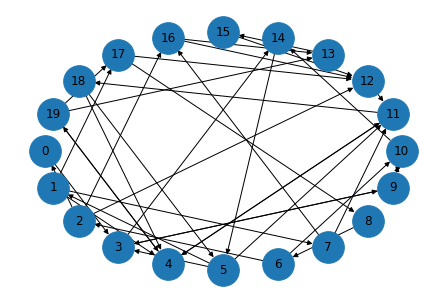

In [4]:
N = 20
grafo = gera(N)
print(len(grafo.edges))
nx.draw(grafo, with_labels=True, node_size=1000, pos = nx.shell_layout(grafo))

**Análise do problema**

É dado um grafo de *input* $G = (V, E)$ conectado e orientado.

Queremos determinar um subgrafo $G' = (V, E')$ de $G$, minimizando $E'$ mas garantindo que o grafo permanece ligado.

Tanto o grafo original como o seu subgrafo podem ser representados por um dicionário de tuplos de arestas denominadas $s$ e $t$, sendo que estes elementos $D_{s,t} \in [0, 1]$ e representam a existência de uma ligacão de $n_s$ a $n_t$.

1.   Logo atráves da afirmação acima concluímos que uma aresta pertencente a $G$ também deve pertencer a $G'$:

$$ \forall_{ (n_s, n_t)\ \in\ G}, \quad 0 \le D_{s,t} \le 1 $$

Para cada par de vértices $(n_s, n_t) \in G$ existe um conjunto de caminhos sem loops tal que $P = \{Paths\}$ que ligam $n_s$ a $n_t$. Para fazer esse calculo usamos a função [`all_simple_paths`](https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.algorithms.simple_paths.all_simple_paths.html).

2.   Portanto para um dado caminho $Paths$ existir, temos que:

$$\prod_{( n_x, n_y )\ \in\ Paths} D_{x, y} = 1 $$

3.   Para garantir a existência desse caminho $Paths \in P$, temos de assegurar que a soma das multiplicações dos dados caminhos são superiores ou iguais a 1, pois se isso nao acontecer o caminho é inacessível e portanto não é válido:

$$ \forall_{( n_s, n_t )\ \in\ G}, \sum_{Paths\ \in\ P} \left( \prod_{( n_x, n_y ) \in Paths} D_{x, y} \right) \ge 1 $$

4.   Devemos então tentar minimizar este número de $G'$:

$$ Minimize\ (\sum_{s=0}\ \sum_{t=0} D_{s,t}) $$


In [8]:
def path_edges(p):
  return [(p[i],p[i+1]) for i in range(len(p)-1)]

As arestas removidas foram [(1, 17), (1, 4), (2, 16), (2, 12), (3, 14), (4, 11), (5, 3), (5, 11), (6, 10), (7, 11), (9, 3), (10, 9), (11, 4), (16, 12), (17, 12), (18, 5), (19, 4), (19, 13)]
O número de arestas removidas foi 18


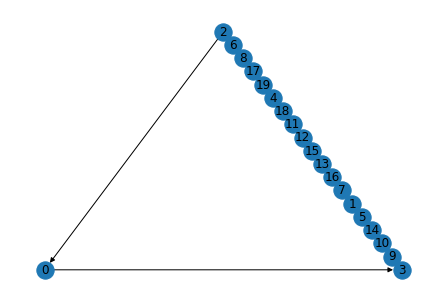

In [9]:
def remove_paths_(grafo):
    N = len(list(grafo.nodes()))
    sol = Optimize()
    d = {}

    for s,t in grafo.edges:
        d[(s,t)] = Int(f"d({s},{t})")
        sol.add(0 <= d[(s,t)], d[(s,t)] <= 1)
    
    # Deve haver sempre um caminho entre cada par de nodos
    for s in grafo.nodes:
        for t in grafo.nodes:
            if(s == t): continue
            l = []
            for p in nx.all_simple_paths(grafo, s, t):
                paths = path_edges(p)
                l.append(Product([d[(x,y)] for x,y in paths]))
            sol.add(Sum(l) >= 1)

    # Minimizar o número de arestas
    sol.minimize(sum(d.values()))

    # Verificar a satisfabilidade
    if sol.check() == sat:
        m = sol.model()
        rem_edges = [(i,j) for i,j in grafo.edges if m[d[i,j]]==0]
        print(f"As arestas removidas foram {rem_edges}")
        print("O número de arestas removidas foi", len(rem_edges))
        r = nx.DiGraph.copy(grafo)
        r.remove_edges_from(rem_edges)
    else:
        r = None
        print("Sem solução")
    return r


graph=remove_paths_(grafo)
nx.draw(graph, with_labels=True, pos = nx.planar_layout(graph))

**Outra Forma**

Nesta segunda versão acrescentamos uma condição que limita inferiormente e superiormente os valores do dicionário com o auxílio da função [`simple_cycles`](https://networkx.org/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html)

As arestas removidas foram [(1, 17), (1, 4), (2, 16), (2, 12), (3, 14), (4, 11), (5, 3), (5, 11), (6, 10), (7, 11), (9, 3), (10, 9), (11, 4), (16, 12), (17, 12), (18, 5), (19, 4), (19, 13)]
O número de arestas removidas foi 18


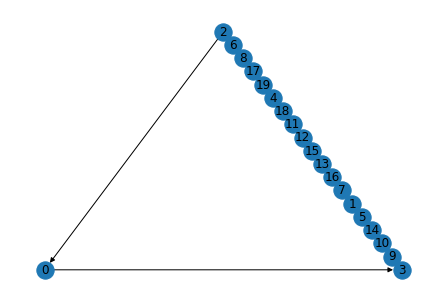

In [10]:
def remove_paths(grafo):
    N = len(list(grafo.nodes()))
    sol = Optimize()
    d = {}

    for s,t in grafo.edges:
        d[(s,t)] = Int(f"d({s},{t})")
        sol.add(0 <= d[(s,t)], d[(s,t)] <= 1)
    
    # Deve haver sempre um caminho entre cada par de nodos
    for s in grafo.nodes:
        for t in grafo.nodes:
            if(s == t): continue
            l = []
            for p in nx.all_simple_paths(grafo, s, t):
                paths = path_edges(p)
                l.append(Product([d[(x,y)] for x,y in paths]))
            sol.add(Sum(l) >= 1)
    
    # Criação de um limite mínimo
    sol.add(sum(d.values()) >= grafo.number_of_nodes())

    # Criação de um limite máximo
    ciclos = [len(ciclo) for ciclo in nx.simple_cycles(grafo)] # buscar o ciclo mais longo
    ciclo = max(ciclos)
    sol.add(sum(d.values()) <= grafo.number_of_nodes() + (grafo.number_of_nodes() - ciclo) * 2)

    # Minimizar o número de arestas
    sol.minimize(sum(d.values()))

    # Verificar a satisfabilidade
    if sol.check() == sat:
        m = sol.model()
        rem_edges = [(i,j) for i,j in grafo.edges if m[d[i,j]]==0]
        print(f"As arestas removidas foram {rem_edges}")
        print("O número de arestas removidas foi", len(rem_edges))
        r = nx.DiGraph.copy(grafo)
        r.remove_edges_from(rem_edges)
    else:
        r = None
        print("Sem solução")
    return r


graph=remove_paths(grafo)
nx.draw(graph, with_labels=True, pos = nx.planar_layout(graph))

**Outra Tentativa**

Também tentamos fazer uma implementação através da função `set_cover` que dada a matriz de incidência determine quais os conjuntos que pertencem à cobertura mínima.

*   O objectivo é minimizar  o somatório de todos os $x_j$, onde cada elemento de  A  tem que  pertencer a pelo menos um conjunto da cobertura.

$$ Minimize\ (\forall i \in A \cdot \sum_{j = 0}^{N-1} A_{i,j} \times x_j \geq 1) $$

Mas acabou por não funcionar como esperavamos...

[0, 3, 9, 10, 14, 5, 11, 4, 19, 17, 8, 6, 2]
[1, 7, 16, 13, 15, 12, 11, 18, 5]
22


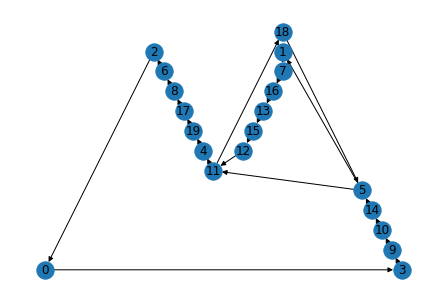

In [11]:
ciclos = list(nx.simple_cycles(grafo))
A = np.zeros((len(ciclos), N))

for ciclo in range(len(ciclos)):
    for nodo in range(N):
        A[ciclo, nodo] = int(nodo in ciclos[ciclo])

def set_cover(A):
    s = Optimize()
    sets = len(A)
    elems = len(A[0])

    x = {}
    for j in range(sets):
        x[j] = Int(str(j))
        s.add(0 <= x[j], x[j] <= 1)

    # Todos os nodos têm de estar presentes
    for i in range(elems):
        s.add(sum(A[j][i]*x[j] for j in range(sets)) >= 1)
  
    soma = sum(A[j][i]*x[j] for j in range(sets) for i in range(elems))
    #s.add((soma <= elems+sum(x.values()) and soma >= elems+1))
    s.add(soma == elems+sum(x.values()))
    
    # Minimizar as vezes que um nodo está presente
    s.minimize(soma)

    if s.check() == sat:
        m = s.model()
        return [j for j in range(sets) if m[x[j]] == 1]
    else:
        print('No optimal solution')

show = nx.DiGraph()
for n in set_cover(A):
    print(ciclos[n])
    show.add_nodes_from(ciclos[n])
    make_cycle(show, ciclos[n])

print(len(show.edges))
nx.draw(show, with_labels=True, pos = nx.planar_layout(show))